In [135]:
pip install textstat

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.1 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.1 MB 509.0 kB/s eta 0:00:04
   ---------- ----------------------------- 0.5/2.1 MB 509.0 kB/s eta 0:00:04
   --------------- ------------------------ 0.8/2.1 MB 516.5 kB/s eta 0:00:03
   --------------- ------------------------ 0.8/2.1 MB 516.5 kB/s eta 0:00:03
   --------------- ------------------------ 0.8/2.1 MB 516.5 kB/s eta 0:00:03
   -------------------- ------------------- 1.0/2.1 MB 513.7 kB/s eta 0:00:03
   -------------------- ------------------- 1.0/2.1 MB 513.7 kB/s eta 0:00:03
   ------------------------- -------------- 1.3/2.1 MB 541.3 kB/s eta 0:00:02
   ------------------------- --

In [16]:
"""
seo_pipeline.ipynb
"""

# %%
# 1. Setup & Imports
import os
import re
import json
import time
from pathlib import Path
from itertools import combinations

import numpy as np
import pandas as pd
from tqdm import tqdm

from bs4 import BeautifulSoup
import requests

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

try:
    import textstat
except Exception:
    textstat = None

try:
    from sentence_transformers import SentenceTransformer
    ST_MODEL = SentenceTransformer('all-MiniLM-L6-v2')
    EMBEDDING_BACKEND = 'sentence-transformers'
except Exception:
    ST_MODEL = None
    EMBEDDING_BACKEND = 'tfidf'

In [11]:
# %%
"""
seo_pipeline.ipynb

Updated to use the user's local dataset path:
C:\\Users\\shrud\\Downloads\\data.csv
"""

# %%
# 1. Setup & Imports
import os
import re
import json
import time
from pathlib import Path
from itertools import combinations

import numpy as np
import pandas as pd
from tqdm import tqdm

from bs4 import BeautifulSoup
import requests

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

try:
    import textstat
except Exception:
    textstat = None

try:
    from sentence_transformers import SentenceTransformer
    ST_MODEL = SentenceTransformer('all-MiniLM-L6-v2')
    EMBEDDING_BACKEND = 'sentence-transformers'
except Exception:
    ST_MODEL = None
    EMBEDDING_BACKEND = 'tfidf'


import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)


# %%
# 2. Paths and config
INPUT_CSV = Path(r"C:\\Users\\shrud\\Downloads\\data.csv")  # user's dataset path
OUTPUT_DIR = Path('.') / 'data'
OUTPUT_DIR.mkdir(exist_ok=True)

EXTRACTED_CSV = OUTPUT_DIR / 'extracted_content.csv'
FEATURES_CSV = OUTPUT_DIR / 'features.csv'
DUPLICATES_CSV = OUTPUT_DIR / 'duplicates.csv'

SIMILARITY_THRESHOLD = 0.80
THIN_WORD_COUNT = 500
RANDOM_SEED = 42

# %%
# 3. Helper functions

def extract_title_and_body(html: str):
    if not html or not isinstance(html, str):
        return '', ''
    soup = BeautifulSoup(html, 'lxml')
    title = soup.title.get_text(strip=True) if soup.title else ''
    article = soup.find(['article', 'main'])
    text_blocks = []
    if article:
        for tag in article.find_all(['p', 'h1', 'h2', 'h3']):
            txt = tag.get_text(strip=True)
            if txt:
                text_blocks.append(txt)
    if not text_blocks:
        for p in soup.find_all('p'):
            txt = p.get_text(strip=True)
            if txt:
                text_blocks.append(txt)
    body = ' '.join(text_blocks)
    return title, re.sub(r'\s+', ' ', body.strip())


def clean_text(txt):
    return re.sub(r'\s+', ' ', txt.lower().strip()) if isinstance(txt, str) else ''

# %%
# 4. Load dataset

def load_dataset(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    return df

# %%
# 5. Scraping fallback
headers = {'User-Agent': 'seo-content-detector/1.0'}

def fetch_html(url, delay=1.0):
    try:
        r = requests.get(url, headers=headers, timeout=10)
        time.sleep(delay)
        return r.text if r.status_code == 200 else ''
    except:
        return ''

# %%
# 6. Feature utilities
import nltk
nltk.download('punkt', quiet=True)
from nltk.tokenize import sent_tokenize, word_tokenize

def compute_basic_metrics(text):
    words = word_tokenize(text)
    sents = sent_tokenize(text)
    return len(words), len(sents)

import textstat
import numpy as np

def compute_readability(text):
    """
    Compute Flesch Reading Ease score safely.
    Returns 0 if text is too short or invalid.
    """
    if not isinstance(text, str) or len(text.split()) < 50:
        return 0
    try:
        score = textstat.flesch_reading_ease(text)
        if np.isnan(score):
            return 0
        return round(score, 2)
    except Exception:
        return 0


# %%
# 7. Main pipeline

def process_dataset():
    df = load_dataset(INPUT_CSV)
    results, texts = [], []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        url = row.get('url', '')
        html = row.get('html_content', '') if 'html_content' in df.columns else ''
        if not html:
            html = fetch_html(url)
        title, body = extract_title_and_body(html)
        body = clean_text(body)
        wc, sc = compute_basic_metrics(body)
        read = compute_readability(body)
        results.append({'url': url, 'title': title, 'body_text': body, 'word_count': wc, 'sentence_count': sc, 'flesch_reading_ease': read, 'is_thin': wc < THIN_WORD_COUNT})
        texts.append(body)

    data = pd.DataFrame(results)
    data.to_csv(EXTRACTED_CSV, index=False)

    tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
    X = tfidf.fit_transform(texts)
    data['embedding'] = [json.dumps(x.tolist()) for x in X.toarray()]

    data.to_csv(FEATURES_CSV, index=False)
    return data, X

# %%
# 8. Duplicate detection

def detect_duplicates(urls, X):
    sim = cosine_similarity(X)
    pairs = []
    for i in range(len(urls)):
        for j in range(i+1, len(urls)):
            if sim[i, j] >= SIMILARITY_THRESHOLD:
                pairs.append({'url1': urls[i], 'url2': urls[j], 'similarity': sim[i, j]})
    dup = pd.DataFrame(pairs)
    dup.to_csv(DUPLICATES_CSV, index=False)
    return dup

# %%
# 9. Label creation and model

def auto_create_labels(df):
    wc_q1 = df['word_count'].quantile(0.33)
    wc_q2 = df['word_count'].quantile(0.66)
    rd_q1 = df['flesch_reading_ease'].quantile(0.33)
    rd_q2 = df['flesch_reading_ease'].quantile(0.66)

    labels = []
    for _, row in df.iterrows():
        wc = row['word_count']
        rd = row['flesch_reading_ease']

        if wc >= wc_q2 and rd >= rd_q2:
            labels.append('High')
        elif wc <= wc_q1 or rd <= rd_q1:
            labels.append('Low')
        else:
            labels.append('Medium')

    df['quality_label'] = labels
    return df



def train_model(df):
    X = df[['word_count', 'sentence_count', 'flesch_reading_ease']]
    y = df['quality_label']
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)
    print(classification_report(yte, ypred))
    print('Accuracy:', accuracy_score(yte, ypred))
    print('F1:', f1_score(yte, ypred, average='weighted'))
    return model

# %%
# 10. Run end-to-end
if __name__ == '__main__':
    print('Running pipeline...')
    features, X = process_dataset()
    dups = detect_duplicates(features['url'].tolist(), X)
    features = auto_create_labels(features)
    model = train_model(features)
    print(f"Duplicate pairs: {len(dups)} | Thin pages: {features['is_thin'].sum()}")


Running pipeline...


100%|██████████| 81/81 [00:08<00:00,  9.62it/s]


              precision    recall  f1-score   support

        High       0.67      1.00      0.80         4
         Low       0.85      1.00      0.92        11
      Medium       1.00      0.60      0.75        10

    accuracy                           0.84        25
   macro avg       0.84      0.87      0.82        25
weighted avg       0.88      0.84      0.83        25

Accuracy: 0.84
F1: 0.8313333333333333
Duplicate pairs: 2 | Thin pages: 35


In [13]:
from joblib import dump
dump(model, 'quality_model.pkl')


['quality_model.pkl']

In [17]:
import json
from sklearn.metrics.pairwise import cosine_similarity
from joblib import load

def analyze_url(url, existing_features_df=None, X_embeddings=None, tfidf_vectorizer=None,
                model_path='quality_model.pkl', threshold=0.5):
    """
    Analyze any given URL for SEO quality and similarity to existing dataset pages.
    """
    # Step 1: Fetch HTML
    headers = {'User-Agent': 'seo-content-detector/1.0'}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        html = response.text if response.status_code == 200 else ''
    except:
        html = ''

    # Step 2: Extract text
    title, body = extract_title_and_body(html)
    body = clean_text(body)

    # Step 3: Compute features
    wc, sc = compute_basic_metrics(body)
    read = compute_readability(body)
    is_thin = wc < 500

    # Step 4: Load model
    from joblib import load
    model = load(model_path)

    X_new = pd.DataFrame([{
        'word_count': wc,
        'sentence_count': sc,
        'flesch_reading_ease': read
    }])
    quality = model.predict(X_new)[0]

    # Step 5: Similarity (uses same TF-IDF vectorizer)
    similar = []
    if tfidf_vectorizer is not None and X_embeddings is not None:
        X_new_vec = tfidf_vectorizer.transform([body])
        sims = cosine_similarity(X_new_vec, X_embeddings).flatten()
        top_idx = np.where(sims >= threshold)[0]
        for i in top_idx:
            similar.append({
                'url': existing_features_df.iloc[i]['url'],
                'similarity': float(sims[i])
            })

    # Step 6: Result
    result = {
        'url': url,
        'title': title,
        'word_count': wc,
        'sentence_count': sc,
        'readability': read,
        'quality_label': quality,
        'is_thin': is_thin,
        'similar_to': similar
    }
    return result


In [19]:
result = analyze_url(
    "https://www.varonis.com/blog/cybersecurity-tips",
    existing_features_df=features,
    X_embeddings=X
)
print(json.dumps(result, indent=2))

{
  "url": "https://www.varonis.com/blog/cybersecurity-tips",
  "title": "Top 10 Cybersecurity Awareness Tips: How to Stay Safe and Proactive",
  "word_count": 1896,
  "sentence_count": 86,
  "readability": 39.79,
  "quality_label": "High",
  "is_thin": false,
  "similar_to": []
}


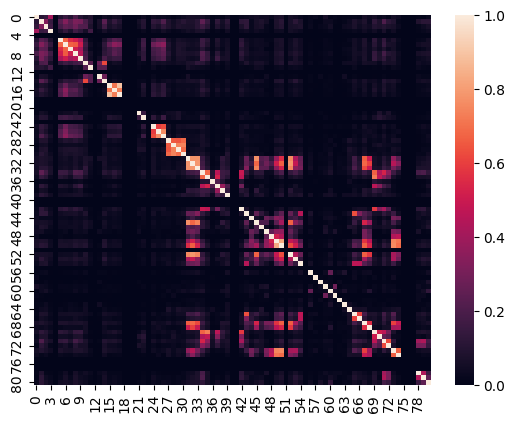

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cosine_similarity(X))
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def train_model(df):
    X = df[['word_count', 'sentence_count', 'flesch_reading_ease']]
    y = df['quality_label']

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)

    print(classification_report(yte, ypred))
    print('Accuracy:', accuracy_score(yte, ypred))
    print('F1:', f1_score(yte, ypred, average='weighted'))

    # ✅ Confusion Matrix
    cm = confusion_matrix(yte, ypred, labels=['Low', 'Medium', 'High'])
    print("Confusion Matrix:")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix: Content Quality Classifier")
    plt.show()

    return model



              precision    recall  f1-score   support

        High       0.67      1.00      0.80         4
         Low       0.85      1.00      0.92        11
      Medium       1.00      0.60      0.75        10

    accuracy                           0.84        25
   macro avg       0.84      0.87      0.82        25
weighted avg       0.88      0.84      0.83        25

Accuracy: 0.84
F1: 0.8313333333333333
Confusion Matrix:
[[11  0  0]
 [ 2  6  2]
 [ 0  0  4]]


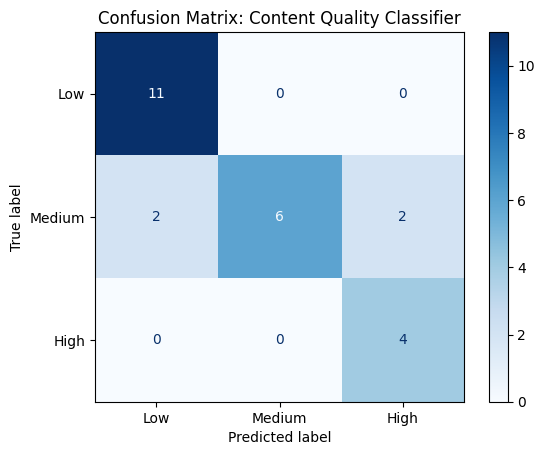

In [25]:
model = train_model(features)

In [27]:
features['quality_label'].value_counts()


quality_label
Low       36
Medium    31
High      14
Name: count, dtype: int64

In [33]:
print("Word count stats:")
print(features['word_count'].describe())

print("\nReadability stats:")
print(features['flesch_reading_ease'].describe())


Word count stats:
count       81.000000
mean      1962.234568
std       3581.539122
min          0.000000
25%         93.000000
50%        639.000000
75%       2183.000000
max      23685.000000
Name: word_count, dtype: float64

Readability stats:
count    81.000000
mean     27.235926
std      24.374303
min     -29.070000
25%       0.000000
50%      28.660000
75%      44.610000
max      82.720000
Name: flesch_reading_ease, dtype: float64


In [35]:
print(features['body_text'].head(5))


0    cyber crisis tabletop exercise cyber security ...
1    top 10 cybersecurity awareness tips: how to st...
2    11 cyber defense tips to stay secure at work a...
3    cybersecurity best practices cybersecurity bes...
4                                                     
Name: body_text, dtype: object


In [37]:
import requests
from sklearn.metrics.pairwise import cosine_similarity
from joblib import load

def analyze_url(url, existing_features_df, tfidf_vectorizer, X_embeddings, threshold=0.5):
    headers = {'User-Agent': 'seo-content-detector/1.0'}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        html = response.text if response.status_code == 200 else ''
    except:
        html = ''

    # Extract and clean
    title, body = extract_title_and_body(html)
    body = clean_text(body)

    wc, sc = compute_basic_metrics(body)
    read = compute_readability(body)
    is_thin = wc < 500

    # Load model
    model = load('quality_model.pkl')
    X_new = pd.DataFrame([{
        'word_count': wc,
        'sentence_count': sc,
        'flesch_reading_ease': read
    }])
    label = model.predict(X_new)[0]

    # Similarity detection
    similar = []
    if tfidf_vectorizer is not None and X_embeddings is not None:
        X_new_vec = tfidf_vectorizer.transform([body])
        sims = cosine_similarity(X_new_vec, X_embeddings).flatten()
        top_idx = np.where(sims >= threshold)[0]
        for i in top_idx:
            similar.append({
                'url': existing_features_df.iloc[i]['url'],
                'similarity': float(sims[i])
            })

    result = {
        'url': url,
        'title': title,
        'word_count': wc,
        'sentence_count': sc,
        'readability': read,
        'quality_label': label,
        'is_thin': is_thin,
        'similar_to': similar
    }
    return result


In [43]:
# --- Build TF-IDF vectorizer for similarity detection ---
from sklearn.feature_extraction.text import TfidfVectorizer

# Use the cleaned body_text column from your features dataframe
texts = features['body_text'].fillna('').tolist()

# Fit TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(texts)

print("TF-IDF vectorizer and embeddings ready for analyze_url()")


TF-IDF vectorizer and embeddings ready for analyze_url()


In [47]:
result = analyze_url(
    "https://discuss.streamlit.io/t/website-on-streamlit-or-django-or-flask/89038",
    existing_features_df=features,
    tfidf_vectorizer=tfidf,
    X_embeddings=X,
    threshold=0.5
)
print(json.dumps(result, indent=2))


{
  "url": "https://discuss.streamlit.io/t/website-on-streamlit-or-django-or-flask/89038",
  "title": "Website on streamlit or django or flask? - Using Streamlit - Streamlit",
  "word_count": 323,
  "sentence_count": 17,
  "readability": 65.98,
  "quality_label": "Medium",
  "is_thin": true,
  "similar_to": []
}
